In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv('Z-Score.csv')
df.describe()

,Age Z-Score,Word Count CTD Z-Score,Total Wait Time (s) CTD Z-Score,Word Count PFT Z-Score,Total Wait Time (s) PFT Z-Score,Word Count SFT Z-Score,Total Wait Time (s) SFT Z-Score,Converted-MMSE Z-Score
count,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,6.900000e+01
mean,-6.788625e-17,-6.435051e-17,6.788625e-17,2.093159e-16,1.131437e-17,-6.717910e-17,-1.838586e-16,-2.574430e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.478846e+00,-1.597409e+00,-9.770136e-01,-1.550017e+00,-2.068063e+00,-1.532262e+00,-1.781651e+00,-3.389311e+00
25%,-3.071703e-01,-7.406723e-01,-7.302057e-01,-7.340293e-01,-7.818143e-01,-7.498617e-01,-6.458403e-01,-1.468506e-01
50%,1.812978e-02,-2.464011e-01,-3.599937e-01,-1.691146e-01,-4.681523e-02,-1.975789e-01,-1.295627e-01,2.584570e-01
75%,5.060798e-01,4.675464e-01,3.804301e-01,5.213367e-01,7.800587e-01,5.387982e-01,5.932260e-01,6.637645e-01
max,2.295230e+00,3.334320e+00,3.835741e+00,3.534215e+00,2.250057e+00,3.254189e+00,2.864847e+00,1.069072e+00


In [29]:
# Überblick über die Datentypen verschaffen
df_info = { "data_types": df.dtypes }
df_info

{'data_types': Record-ID                           object
 TrainOrDev                          object
 Class                               object
 Gender                              object
 Age Z-Score                        float64
 Word Count CTD Z-Score             float64
 Total Wait Time (s) CTD Z-Score    float64
 Word Count PFT Z-Score             float64
 Total Wait Time (s) PFT Z-Score    float64
 Word Count SFT Z-Score             float64
 Total Wait Time (s) SFT Z-Score    float64
 Converted-MMSE Z-Score             float64
 dtype: object}

In [30]:
# Numerische Spalten für die Korrelationsanalyse
numeric_columns = df.select_dtypes(include = ['float64']).columns
correlation_matrix = df[numeric_columns].corr()

# Korrelation der numerischen Spalten mit "Converted-MMSE"
mmse_correlation = correlation_matrix['Converted-MMSE Z-Score'].sort_values(ascending = False)
mmse_correlation

Converted-MMSE Z-Score             1.000000
Word Count CTD Z-Score             0.194882
Word Count SFT Z-Score             0.004747
Total Wait Time (s) PFT Z-Score   -0.176075
Word Count PFT Z-Score            -0.231698
Total Wait Time (s) SFT Z-Score   -0.284651
Age Z-Score                       -0.335210
Total Wait Time (s) CTD Z-Score   -0.369492
Name: Converted-MMSE Z-Score, dtype: float64

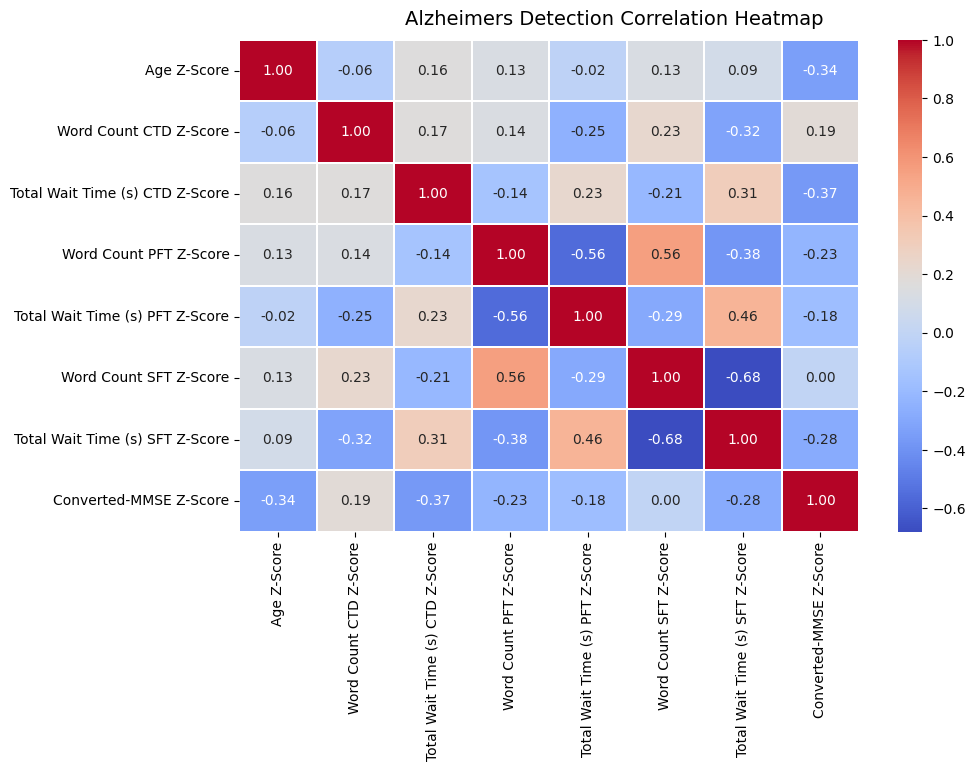

In [31]:
# Pair-wise Correlation Matrix Heatmap
f, ax = plt.subplots(figsize = (10, 6))
corr = df.corr(numeric_only = True)
hm = sns.heatmap(round(corr, 2), annot = True, ax = ax, cmap = "coolwarm", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = 0.93)
t = f.suptitle('Alzheimers Detection Correlation Heatmap', fontsize = 14)

In [33]:
# Datenvorbereitung
# Merkmale mit signifikanter Korrelation auswählen
features = ['Word Count PFT Z-Score', 'Word Count SFT Z-Score', 'Total Wait Time (s) PFT Z-Score', 'Word Count PFT Z-Score']

# Daten ohne fehlende Werte (für Modelltraining)
train_data = df.dropna(subset = ['Converted-MMSE Z-Score'])
X_train = train_data[features]
y_train = train_data['Converted-MMSE Z-Score']

# Fehlende Werte für Vorhersage
missing_data = df[df['Converted-MMSE Z-Score'].isnull()]
X_missing = missing_data[features]

# Train-Test-Split (für Modellbewertung)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size = .2, random_state = 42)

# Modelltraining
rf_model = RandomForestRegressor(random_state = 42, n_estimators = 100)
rf_model.fit(X_train_split, y_train_split)

# Modellbewertung
y_pred = rf_model.predict(X_test_split)
rmse = mean_squared_error(y_test_split, y_pred, squared = False)

# Fehlende Werte vorhersagen
missing_predictions = rf_model.predict(X_missing)

# RMSE ausgeben und fehlende Werte imputieren
# Zeigt die RMSE und die ersten 5 Vorhersagen
rmse, missing_predictions[:5]

C:\Users\BenLa\miniconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(0.7514837324746675),
 array([-0.66159115,  0.70834837,  0.19360778,  0.42058001,  0.60702148]))

In [34]:
# Sicherstellen, dass Indizes korrekt sind
missing_indices = df[df['Converted-MMSE Z-Score'].isnull()].index

# Fehlende Werte durch Vorhersagen ersetzen
df.loc[missing_indices, 'Converted-MMSE Z-Score'] = missing_predictions.round().astype(int)

<Axes: ylabel='Converted-MMSE Z-Score'>

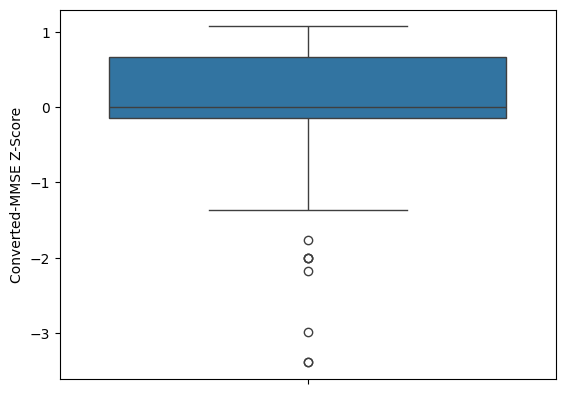

In [35]:
# Boxplot
sns.boxplot(data=df['Converted-MMSE Z-Score'])

<Axes: ylabel='Converted-MMSE Z-Score'>

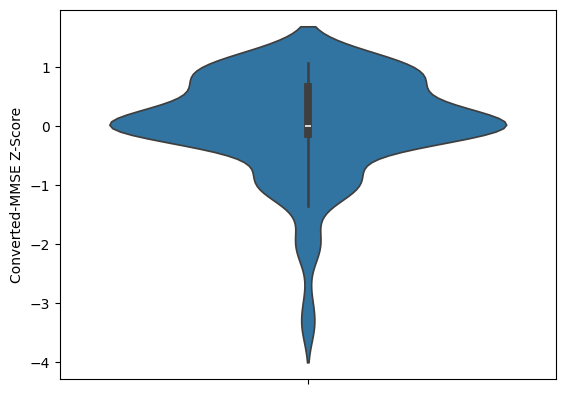

In [36]:
# Violinplot
sns.violinplot(data=df['Converted-MMSE Z-Score'])

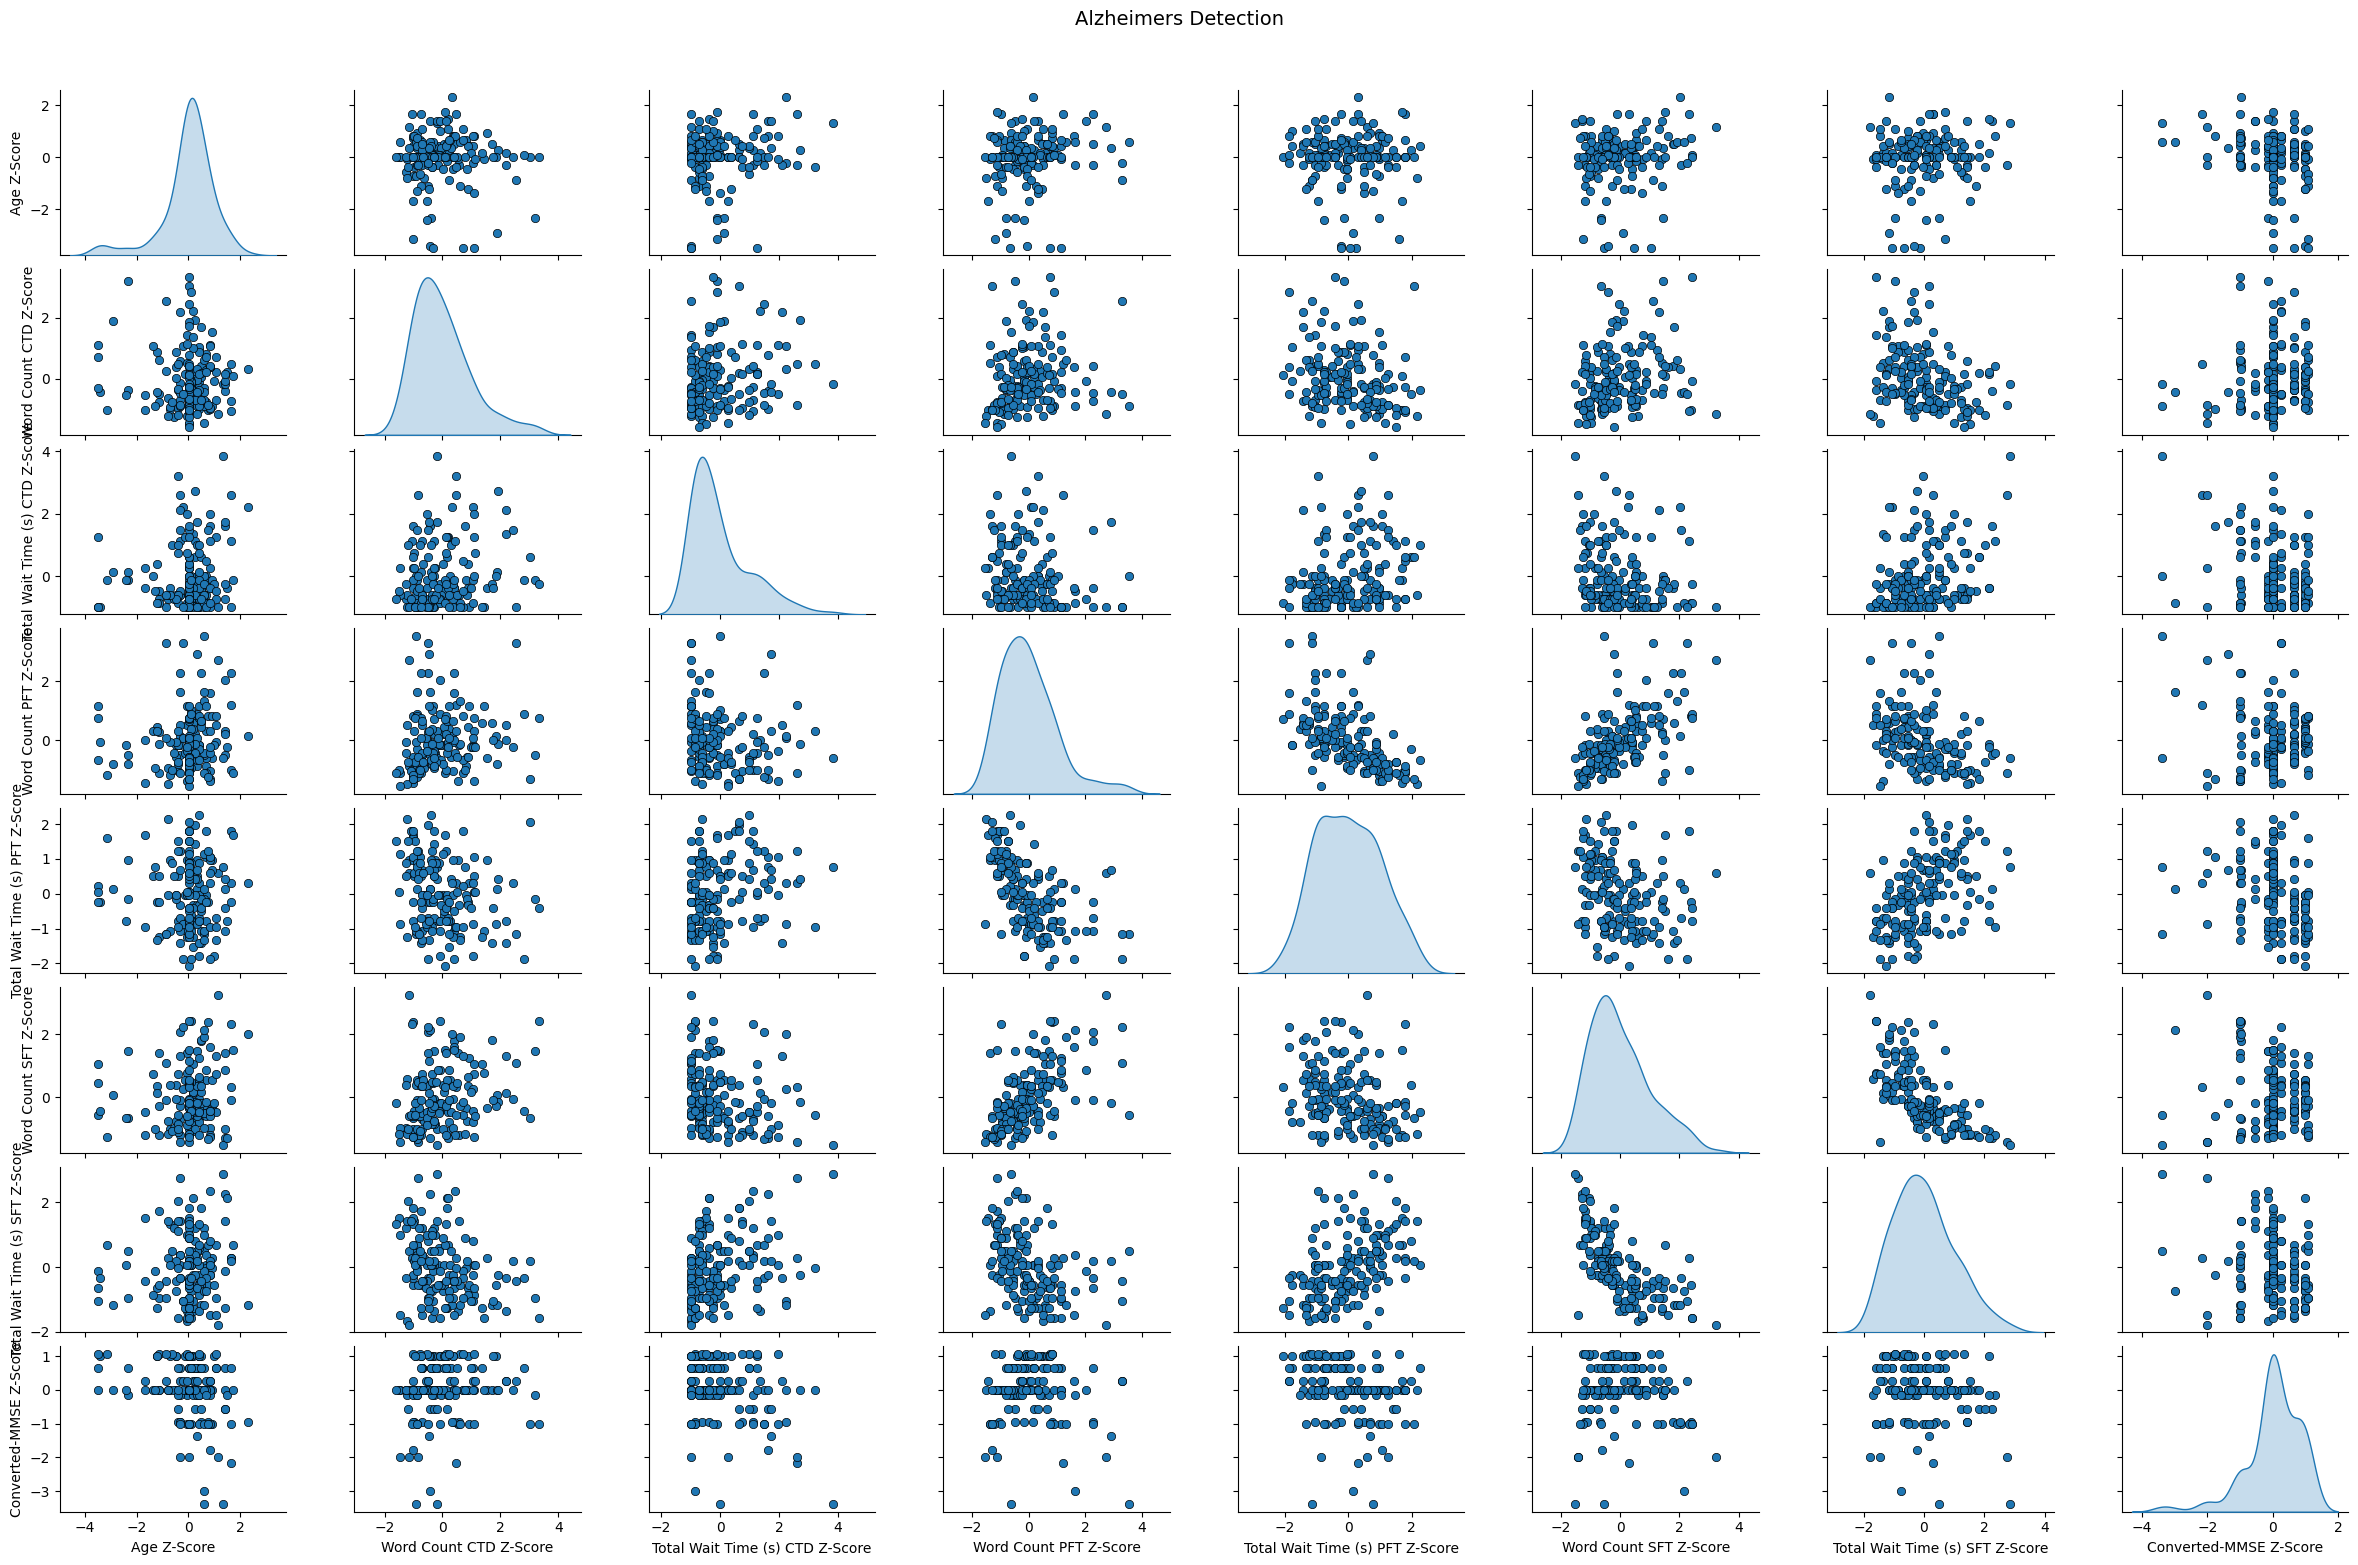

In [37]:
# Pair-wise Scatter Plots
pp = sns.pairplot(df, height = 2, aspect = 1.5, # set height of each facet to 2 inches and width to 2 * 1.5 inches
                  plot_kws = dict(edgecolor = "k", linewidth = .5), # change edges of points to thin black
                  diag_kind = "kde", diag_kws = dict(fill = True)) # set diagonal charts, kws = keyword arguments

fig = pp.fig
fig.subplots_adjust(top = .93, wspace = .3) # increase top space and white spaces between the plots
fig.suptitle('Alzheimers Detection', fontsize = 14); # add title to figure

In [38]:
# Gespeicherte Tabelle mit ausgefüllten Werten
df.to_csv("Filled_mmse-Z-Score.csv", index = False)